In [1]:
############ Calculate Horizon Distances #################
import pycbc.psd
import numpy

from pycbc.waveform import get_fd_waveform
from pycbc.filter import sigma
from pycbc.cosmology import redshift

import tqdm

dur = 32
sr = 10000
flow = 5.05
df = 1.0 / dur
tlen = sr * dur
flen = tlen // 2 + 1

det_masses = numpy.logspace(-1, 3.6, 300)

############# CE designs noise ###################################

ce_40k_lf_hp = pycbc.psd.from_txt("ce_strain/cosmic_explorer_40km_lf_hp_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)

ce_40k_det = pycbc.psd.from_txt("ce_strain/cosmic_explorer_40km_lf_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)

ce_40k_base = pycbc.psd.from_txt("ce_strain/cosmic_explorer_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)

ce_20k_base = pycbc.psd.from_txt("ce_strain/cosmic_explorer_20km_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)


ce_20k_pm = pycbc.psd.from_txt("ce_strain/cosmic_explorer_20km_pm_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)


aplus = pycbc.psd.from_txt("ligo_strain/AplusDesign.txt",
                            flen, df, flow,
                            is_asd_file=True)

asharp = pycbc.psd.from_txt("ligo_strain/Asharp_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)

o3ref = pycbc.psd.from_txt("ligo_strain/o3.txt", flen, df, 15.0,
                           is_asd_file=True)
    
ce_psds = {'CE:LowFreqHighPower':ce_40k_lf_hp,
           'CE:LowFreq':ce_40k_det,
           'CE:Broad': ce_40k_base, 
           'CE:20km': ce_20k_base,
           'CE:20kmPostmerger': ce_20k_pm,
           'A+':aplus,
           'A#':asharp,
           'O3':o3ref,
          }
############ read in noise budget ###################
import numpy
from pycbc.types import FrequencySeries

noise = numpy.genfromtxt('ce_strain/CEnoisebudget.csv', delimiter=',', names=True)

names = list(noise.dtype.names)
names.remove('Frequency')

freq = noise['Frequency']

f = numpy.arange(0, 6000, df)

noise_psds = {}

for t in names:
    noise_psds[t] = FrequencySeries(numpy.interp(f, freq, noise[t]), delta_f=df)
    

noise_psds['FacilityLimit'] = noise_psds['Newtonian'] + noise_psds['ExcessGas']

################ get horizons distance ##################
signal_amp_limit = {k: [] for k in noise_psds}
signal_amp = {k: [] for k in ce_psds}
for m in tqdm.tqdm(det_masses):
    hp, hc = get_fd_waveform(approximant="IMRPhenomXPHM",
                             mass1=m,
                             mass2=m,
                             f_lower=flow,
                             delta_f=df,
                             f_final=2048,
                             )
    for k in noise_psds:
        hp.resize(len(noise_psds[k]))
        amp = sigma(hp, psd=noise_psds[k]**2.0, low_frequency_cutoff=flow)
        signal_amp_limit[k].append(amp)
        
    for k in ce_psds:
        p = ce_psds[k]
        hp.resize(len(p))
        
        fl = flow 
        if k in ['O3']:
            fl = 15.0
        if k in ['A+', 'A#']:
            fl = 10.0
        amp = sigma(hp, psd=p, low_frequency_cutoff=fl)
        signal_amp[k].append(amp)

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 10.75it/s]


In [2]:
########### Generate Populations ################
from pycbc.distributions import draw_samples_from_config
import os.path
import numpy.random
import h5py

if os.path.exists('./_population_saved.hdf'):
    f = h5py.File('./_population_saved.hdf', 'r')
    bns = f['bns'][:]
    bbh = f['bbh'][:]
else:
    bns = draw_samples_from_config('populations/bns.ini', int(1e6))
    bbh = draw_samples_from_config('populations/bbh.ini', int(1e5))
    f = h5py.File('./_population_saved.hdf', 'w')
    f['bns'] = bns
    f['bbh'] = bbh
    
#fiducial nsbh population
nsbh = {}
nsbh['redshift'] = bns['redshift'][0:50000] # close enough...
nsbh['mass'] = numpy.random.lognormal(numpy.log(10), 0.25, size=len(nsbh['redshift']))

In [3]:
# Generate fiducial pop III population
import numpy.random
psize = 200
popthree = {}
popthree['redshift'] = numpy.random.normal(17, 5, size=psize)
popthree['mass'] = numpy.random.lognormal(numpy.log(55), 0.9, size=psize)

# quick and dirty eyeball from here temporarily 2303.15515.pdf

In [4]:
# Generate fiducial  QCD Phase transition PBHs
import numpy.random
from scipy.stats import loguniform

x = loguniform(.1, 50).rvs(size=10)
print(x)

psize = 10000
pbh = {}
pbh['mass'] = []
#pbh['mass'] = numpy.random.normal(0.7*2.0, 6.0, size=psize)
pbh['mass'] = numpy.concatenate([pbh['mass'], numpy.random.lognormal(0.7*1.2, 2.5, size=psize)])

#pbh['mass'] = numpy.concatenate([pbh['mass'], loguniform(.1, 100).rvs(size=psize)])

pbh['redshift'] = numpy.log(numpy.random.uniform(0, numpy.e**0.25, size=len(pbh['mass'])))*1200 * 12.0 / 3.0

pbh['alpha'] = 100 / pbh['redshift']
k = (pbh['alpha'] > 1) | (pbh['alpha'] < 0)
pbh['alpha'][k] = 1

print(pbh['alpha'].min(), pbh['alpha'].max())
print(pbh['redshift'].min())


[ 0.6664703   2.45164133  0.59720693  0.110368    2.16079216  0.46119646
 24.41200471  1.48183725  0.84672832 14.33405331]
0.08334627076143883 1.0
-42752.0714450197


In [5]:
!wget -nc -O PEtable.txt https://github.com/gwastro/4-ogc/raw/master/posterior/PEtable.txt
    
import numpy
catalog = numpy.genfromtxt("./PEtable.txt", delimiter=',', skip_header=1)
cat_mtotal = catalog[:,1] + catalog[:, 4]
cat_redshift = catalog[:,19]

File ‘PEtable.txt’ already there; not retrieving.


In [6]:
# Switf grbs from https://swift.gsfc.nasa.gov/archive/grb_table.html/table.php?obs=Swift&year=All+Years&restrict=redshifts&redshift=1&bat_t90=1
import numpy
import re
grbs = numpy.genfromtxt("./grb_table_1683581796.txt", delimiter='\t', skip_header=1, dtype=str)
t90 = grbs[:,1]
gredshift = grbs[:,2]
grb_z = []
for r, t in zip(gredshift, t90):
    try:
        if float(t) < 2.0:
            grb_z.append(float(re.findall("\d+\.\d+", r)[0]))
    except ValueError:
        continue

[580, 1400, 2600]


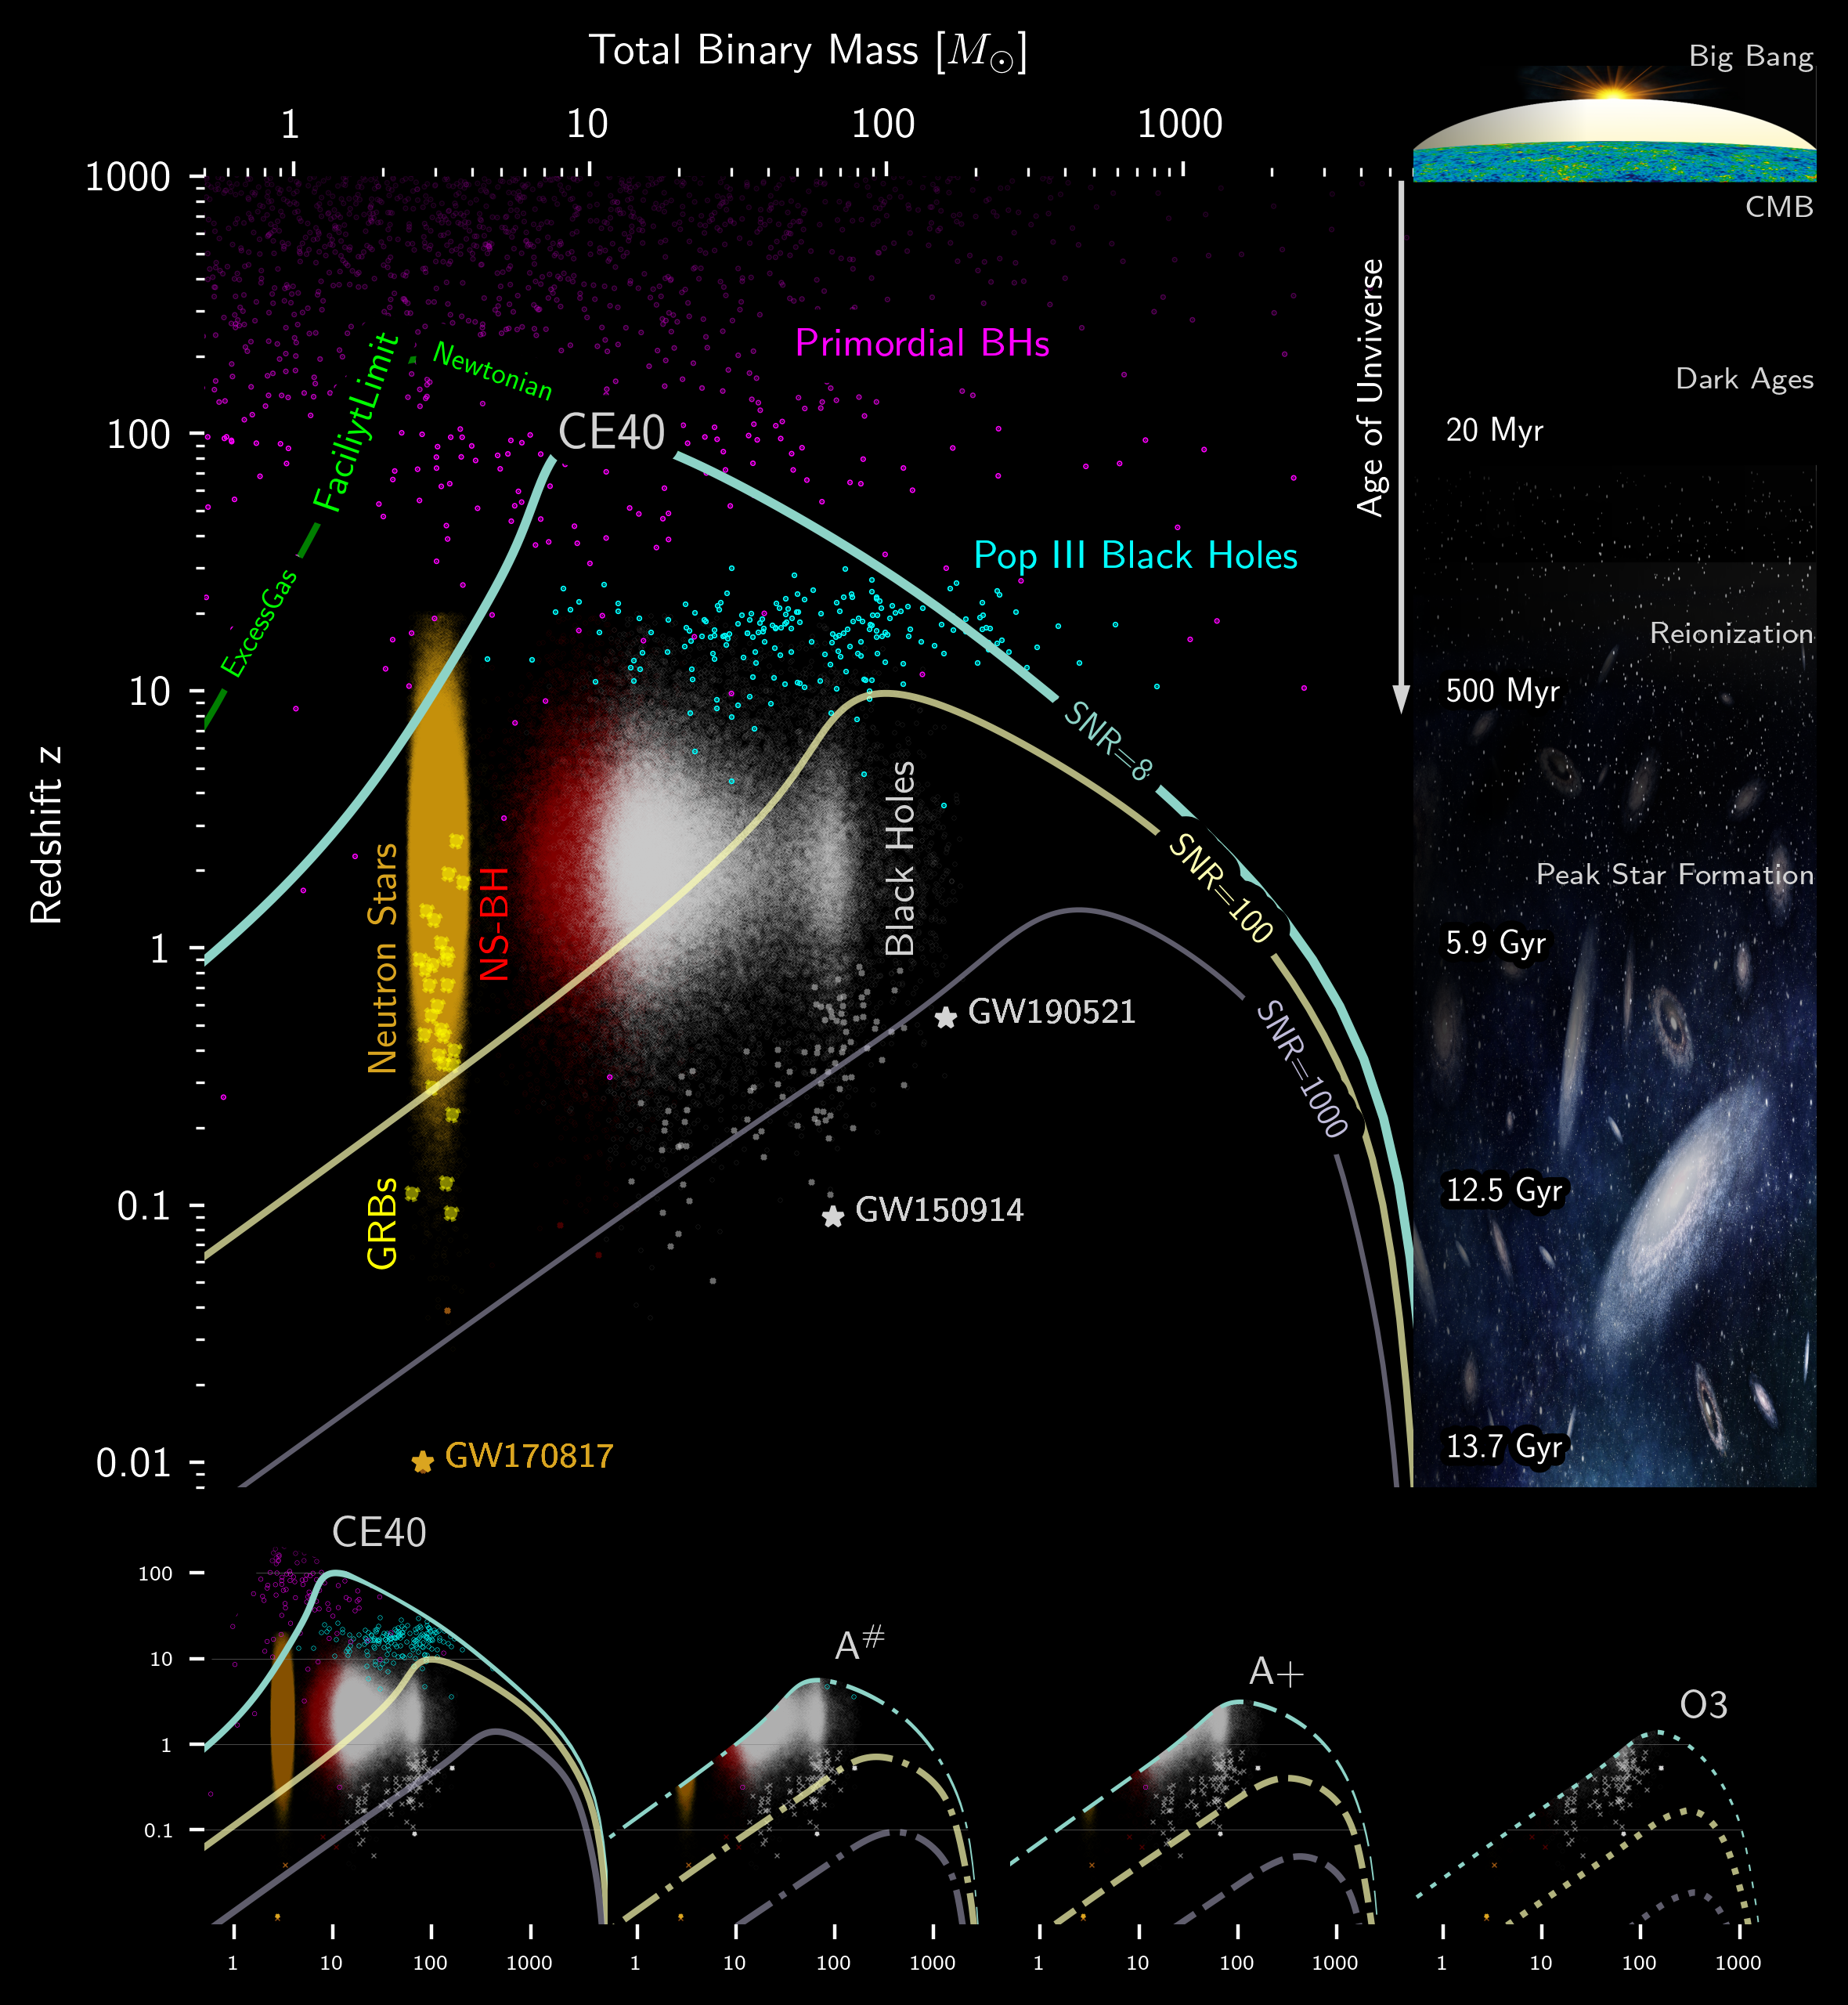

In [13]:
# Make plot ##########
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
from labellines import labelLine, labelLines, labelLine
from scipy.interpolate import interp1d
import matplotlib.patheffects as path_effects
from matplotlib import rcParams


style = 'black'

bns_color = 'goldenrod'
pbh_color = 'magenta'

if style == 'white':
    plt.style.use('default')
    bgcolor = 'white'
    hcolor = 'darkgrey'
    nsbh_color = '#FF0000'
    nsbh_text_color = nsbh_color
    bhcolor = 'black'
    tcolor = 'black'
    pt_color = 'blue'
    snr_color = 'blue'
    faccolor = 'green'
    grb_color = 'olive'
else:
    plt.style.use('dark_background')
    grb_color = 'yellow'
    pt_color = 'cyan'
    bgcolor = 'black'
    nsbh_color = 'darkred'
    nsbh_text_color = 'red'
    hcolor = 'black'
    bhcolor = 'lightgrey'
    snr_color = 'cyan'
    tcolor = 'white'
    faccolor = '#00FF00'
    
plt.rc('text', usetex=True)
rcParams["font.family"] = "sans-serif"
#rcParams["font.serif"] = "stix"
#plt.rcParams["mathtext.fontset"] = "stix"


fig = plt.figure(figsize=[6, 6.5], dpi=400)
gs = plt.GridSpec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[3, 1], wspace=0, hspace=0)

ax = fig.add_subplot(gs[0,:3])
ax2 = [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1]), fig.add_subplot(gs[1,2]), fig.add_subplot(gs[1,3])]
axs = [ax, ax2[0], ax2[1], ax2[2], ax2[3]]


axs[0].set_ylabel('Redshift z')
axs[0].set_xlabel('Total Binary Mass [$M_\odot$]', labelpad=10)
axs[0].xaxis.tick_top()
axs[0].xaxis.set_label_position('top') 

for ax in axs:
    ax.set_ylim(0.008, 1000)
    ax.set_xlim(0.5, 6000)
    #plt.xlim(1, 300)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.sca(ax)
    plt.xticks([1, 10, 100, 1000], [1, 10, 100, 1000])
    plt.yticks([.01, .1, 1, 10, 100, 1000], [.01, .1, 1, 10, 100, 1000])    
    
for ax in ax2:
    #ax.get_yaxis().set_visible(False)
    #ax.get_xaxis().set_visible(False)
    plt.sca(ax)
    if ax is ax2[0]:
        plt.yticks([.1, 1, 10, 100], [.1, 1, 10, 100], fontsize=5)
    else:
        plt.yticks([], [])
        
    plt.xticks(fontsize=5)
    #plt.grid(zorder=999999, axis='y', linewidth=0.1, color='grey')
    
    for z in [.1, 1, 10, 100]:
        ax.axhline(z, linewidth=0.1, color='grey')
    
    pass


snrs = [8, 100, 1000]


# add facility horizon limit ###################################
ldist_horizon = numpy.array(signal_amp_limit['FacilityLimit']) / snrs[0]
z = redshift(ldist_horizon)
src_mass = det_masses / (1 + z) * 2.0
axs[0].plot(src_mass, z, label="FaciliytLimit", linestyle='-', alpha=0.5, color=faccolor)
labelLine(axs[0].get_lines()[-1], 1.7, align=True, fontsize=9, alpha=1.0)    
labelLine(axs[0].get_lines()[-1], 0.8, 'ExcessGas', align=True, fontsize=7, alpha=1.0)
labelLine(axs[0].get_lines()[-1], 5, 'Newtonian', align=True, fontsize=7, alpha=1.0)
i2 = interp1d(src_mass, z, fill_value='extrapolate')

# add horizon distance lines ####################################
pos = [580, 1400, 2600]

ltext = ["BH \& NS Throughout Cosmic Time",
         "Fundamental physics from rare obs.",
         "Precision NS Dense Matter and GR"]
ltextpos = [100, 30, 10]
for snr, alpha, spos, lw, lt, ltp in zip(snrs, [1, 0.7, 0.5, 0.3],
                                     pos, [2.1, 1.6, 1.2, 1.2], ltext, ltextpos):
    # 40k
    z = redshift(numpy.array(signal_amp['CE:Broad']) / snr)
    src_mass = det_masses * 2.0 / (1 + z) 
    p1 = axs[0].plot(src_mass, z, alpha=alpha, linestyle='-',
                     linewidth=lw, zorder=999)
    i1 = interp1d(src_mass, z, fill_value='extrapolate')
    
    p100 = axs[1].plot(src_mass, i1(src_mass), alpha=alpha, 
                       linestyle='-', color=p1[-1].get_color(),)

    if snr == snrs[0]:
        axs[1].fill_between(src_mass, i2(src_mass) * 1.10, 1000, 
                            color=hcolor, zorder=999)        
        
    # A+
    z = redshift(numpy.array(signal_amp["A+"]) / snr)
    src_mass = det_masses * 2.0 / (1 + z)    
    p6 = axs[3].plot(src_mass, z, 
            color=p1[-1].get_color(), linestyle='dashed', alpha=alpha)
    if snr == snrs[0]:
        axs[3].fill_between(src_mass, z*1.10, 1000, color=hcolor, zorder=10)       
    
    # A#
    z = redshift(numpy.array(signal_amp["A#"]) / snr)
    src_mass = det_masses * 2.0 / (1 + z)    
    p7 = axs[2].plot(src_mass, z, 
            color=p1[-1].get_color(), linestyle='dashdot', alpha=alpha)
    if snr == snrs[0]:
        axs[2].fill_between(src_mass, z*1.10, 1000, color=hcolor, zorder=999)       
  
    # O3
    z = redshift(numpy.array(signal_amp["O3"]) / snr)
    src_mass = det_masses * 2.0 / (1 + z)    
    
    p8 = axs[4].plot(src_mass, z, 
            color=p1[-1].get_color(), linestyle='dotted', alpha=alpha)
    if snr == snrs[0]:
        axs[4].fill_between(src_mass, z*1.10, 1000, color=hcolor, zorder=999)     

    #axs[0].text(1, 500, "Cosmic Explorer 40km",
    #           color='black', fontsize=13)
    
    if snr == snrs[0]:
        labelLine(p1[0], 12, label='CE40', align=False, fontsize=12, zorder=1000, color=bhcolor)

        #labelLine(p100[0], 12, label='CE40', align=False, fontsize=10, zorder=1000)
        #labelLine(p6[0], 90, label='A$+$', align=False, fontsize=9, zorder=10000)
        #labelLine(p7[0], 100, label='A$^{\#}$', align=False, fontsize=9, zorder=1000)
        #labelLine(p8[0], 150, label='O3', align=False, fontsize=9, zorder=1000)       
        
        axs[1].text(10, 200, 'CE40', fontsize=10, zorder=1000, color=bhcolor)
        axs[3].text(130, 5, 'A$+$', fontsize=9, zorder=10000, color=bhcolor)
        axs[2].text(100, 10, 'A$^\#$', fontsize=9, zorder=1000, color=bhcolor)
        axs[4].text(250, 2, 'O3', fontsize=9, zorder=1000, color=bhcolor)


    labelLine(p1[0], spos, label=f"SNR={snr}",
              fontsize=8, zorder=1000, alpha=1.0)
    
# add interesting single events#################################
from pycbc.catalog import Merger


for i, ax in enumerate(axs):
    fac = 1
    if i >= 1:
        fac =  (.33) ** 2
        
    m = Merger("GW170817")
    x, y = m.mass1 + m.mass2, m.redshift

    ax.plot(x, y, '*', color=bns_color, markersize=5 * fac, zorder=10)
    axs[0].text(x*1.2, y/1.05, 'GW170817', fontsize=8, color=bns_color, zorder=9)

    m = Merger("GW150914")
    x, y = m.mass1 + m.mass2, m.redshift

    ax.plot(x, y, '*', color=bhcolor, markersize=5 * fac, zorder=10)
    
    axs[0].text(x*1.2, y/1.05, 'GW150914', fontsize=8, color=bhcolor, zorder=9)


    ax.scatter(cat_mtotal[cat_mtotal>12], cat_redshift[cat_mtotal>12], marker='x', 
               s=0.3 * fac,
               color=bhcolor, alpha=0.5, rasterized=True)

    ax.scatter(cat_mtotal[cat_mtotal<12], cat_redshift[cat_mtotal<12], marker='x', 
               s=0.3 * fac,
               color=nsbh_color, alpha=0.5, rasterized=True)

    ax.scatter(cat_mtotal[cat_mtotal<4], cat_redshift[cat_mtotal<4], marker='x', 
               s=0.3 * fac,
               color=bns_color, alpha=0.5, rasterized=True)

    i = cat_mtotal.argmax()
    x, y = cat_mtotal[i], cat_redshift[i]

    ax.plot(x, y, '*', color=bhcolor, markersize=5 * fac, zorder=10)
    axs[0].text(x*1.2, y/1.05, 'GW190521', fontsize=8, color=bhcolor, zorder=9)


##################################################
# Add populations of events
for i, ax in enumerate(axs):
    fac = 1
    if i >= 1:
        fac =  (.33) ** 2
    ax.scatter(bns['srcmass1'] + bns['srcmass2'], bns['redshift'],
               s=0.001 * fac, rasterized=True, alpha=0.25, color=bns_color)
    ax.scatter(bbh['srcmass1'] + bbh['srcmass2'], bbh['redshift'],
               s=0.001 * fac, rasterized=True, alpha=0.5, color=bhcolor)
    ax.scatter(popthree['mass'], popthree['redshift'], color=pt_color, s=0.1 * fac, alpha=1.0)
    
    
    ax.scatter(pbh['mass'], pbh['redshift'],
               color=pbh_color, s=0.35 * fac, alpha=pbh['alpha'], marker='.', rasterized=True)
    ax.scatter(nsbh['mass'], nsbh['redshift'], 
               color=nsbh_color, s=0.05 * fac,
               alpha=0.2, marker='.', zorder=-1, rasterized=True)

axs[0].text(1.8, .35, 'Neutron Stars', rotation=90, fontsize=9, color=bns_color)
axs[0].text(4.3, .8, 'NS-BH', rotation=90, fontsize=9, color=nsbh_text_color)
axs[0].text(100.0, 1.0, 'Black Holes', rotation=90, fontsize=9, color=bhcolor)
axs[0].text(200.0, 30, 'Pop III Black Holes', fontsize=9, color=pt_color)
axs[0].text(50, 200, 'Primordial BHs', fontsize=9,
            color=pbh_color, backgroundcolor=bgcolor)

############ plot universe timeline ################
from PIL import Image

#x1,x2,y1,y2 = axu.axis()
#ax3 = axu.axis((x1, x2, y1, y2))

axu = fig.add_subplot(gs[0,3], ymargin=-0.4, xmargin=0.4)
print(pos)

if style == 'white':
    img = numpy.asarray(Image.open('./universe_white.png')) 
else:
    img = numpy.asarray(Image.open('./universe2.png'))
imgplot = axu.imshow(img, aspect='auto')
axu.get_xaxis().set_visible(False)
axu.set_axis_off()

for text, pos in zip(['Big Bang',
                      'CMB', 'Dark Ages', 
                      'Reionization', 'Peak Star Formation'],
                     [0, 
                      350, 750, 1340, 1900]):
    axu.text(1000, pos, text, color=bhcolor, fontsize=7,
             horizontalalignment='right')


from astropy.cosmology import Planck15
Planck15.age(2)


def round_sig(x, sig=2):
    return round(x, sig-int(numpy.floor(numpy.log10(abs(x))))-1)

pos = [3230, 2635, 2060, 1475, 870,
       #300,
      ]
zs = [.01, .1, 1, 10, 100, 
      #1000,
     ]
labels = []
for p, z in zip(pos, zs):
    age = Planck15.age(z).value * 1e9

    if age > 1e9:
        txt = '%2.1f Gyr' % round_sig(age / 1e9, sig=3)
    elif age > 1e6:
        txt = '%2.0f Myr' % round_sig(age / 1e6, sig=1)
    elif age > 1e3:
        txt = '%2.0f Kyr' % round_sig(age / 1e3, sig=1)
    labels.append(txt)
    
    text = axu.text(80, p, txt, horizontalalignment='left',
                    fontsize=8, color=tcolor)
    text.set_path_effects([path_effects.Stroke(linewidth=4, foreground=bgcolor),
                       path_effects.Normal()])
    
    #axu.axhline(p - 20, xmin=.97, xmax=1, color='white', linewidth=0.5)

############short grbs with redshift from Swift ########
axs[0].scatter((bns['srcmass1'] + bns['srcmass2'])[0:len(grb_z)],
               grb_z, color=grb_color,  linestyle='dotted', marker='.', alpha=0.5)
axs[0].text(1.8, 0.060, 'GRBs', fontsize=9,
            rotation=90, color=grb_color)

fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
f
pos = axu.get_position()
pos.y1=0.96
pos.x2=1.0
axu.set_position(pos)


axs[0].arrow(0.99, .995, 0, -0.4,
             color=bhcolor,
             transform=axs[0].transAxes, 
             length_includes_head=True, head_width=.01)
axs[0].text(3900, 50, 'Age of Unviverse', rotation=90, fontsize=8)

plt.savefig('znb_%s.pdf' % style, bbox_inches='tight', pad_inches=0)

In [8]:
# A+
snr = 10
z = redshift(numpy.array(signal_amp["A+"]) / snr)
src_mass = det_masses * 2.0 / (1 + z)
i2 = interp1d(src_mass, z)

# A#
snr = 10
z = redshift(numpy.array(signal_amp["A#"]) / snr)
src_mass = det_masses * 2.0 / (1 + z)
i3 = interp1d(src_mass, z)
    
# A#
snr = 5
z = redshift(numpy.array(signal_amp["A#"]) / snr)
src_mass = det_masses * 2.0 / (1 + z)
i4 = interp1d(src_mass, z)

print(i2(20), i3(200), i4(20))

0.7014610632431619 3.637690340777006 4.58240317756079
